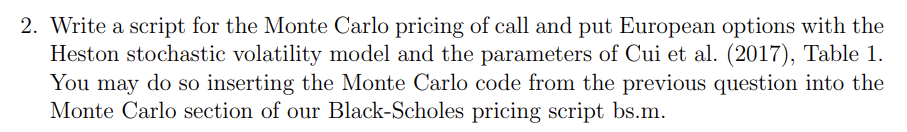

In [28]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.fft import fft, ifftshift, fftshift,ifft
from mpl_toolkits.mplot3d import Axes3D
import time
import pandas as pd

In [29]:
from scipy.special import gamma
def charfunction(xi, parameters, flag=0):
    """
    Compute the characteristic function for different pricing problems.
    :param xi: Fourier space grid.
    :param parameters: Parameters for the distributions.
    :param flag: Flag for backward (0) or forward (1) characteristic function.
    :return: Characteristic function.
    """
    meancorrection = (parameters['rf'] - parameters['q']) * parameters['dt'] - \
                     np.log(charfunction0(-1j, parameters))
    F = np.exp(1j * meancorrection * xi) * charfunction0(xi, parameters)
    if flag == 0:
        F = np.conj(F)
    return F

def charfunction0(xi, parameters):
    """
    Compute the characteristic function for various distributions.
    :param xi: Fourier space grid.
    :param parameters: Parameters for the distributions.
    :return: Characteristic function.
    """
    distr_type = parameters['distr']
    
    if distr_type == 1:  # Normal
        m = parameters['m']
        s = parameters['s']
        F = np.exp(1j * xi * m - 0.5 * (s * xi)**2)

    elif distr_type == 2:  # NIG
        alpha = parameters['alpha']
        beta = parameters['beta']
        delta = parameters['delta']
        F = np.exp(-delta * (np.sqrt(alpha**2 - (beta + 1j * xi)**2) - np.sqrt(alpha**2 - beta**2)))

    elif distr_type == 3:  # VG
        theta = parameters['theta']
        s = parameters['s']
        nu = parameters['nu']
        F = (1 - 1j * xi * theta * nu + 0.5 * nu * (s * xi)**2)**(-1 / nu)

    elif distr_type == 4:  # Meixner
        alpha = parameters['alpha']
        beta = parameters['beta']
        delta = parameters['delta']
        F = (np.cos(beta / 2) / np.cosh((alpha * xi - 1j * beta) / 2))**(2 * delta)

    elif distr_type == 5:  # CGMY
        C = parameters['C']
        G = parameters['G']
        M = parameters['M']
        Y = parameters['Y']
        F = np.exp(C * gamma(-Y) * ((M - 1j * xi)**Y - M**Y + (G + 1j * xi)**Y - G**Y))

    elif distr_type == 6:  # Kou
        s = parameters['s']
        lambd = parameters['lambda']
        pigr = parameters['pigr']
        eta1 = parameters['eta1']
        eta2 = parameters['eta2']
        F = np.exp(-0.5 * (s * xi)**2 + lambd * ((1 - pigr) * eta2 / (eta2 + 1j * xi) + pigr * eta1 / (eta1 - 1j * xi) - 1))

    elif distr_type == 7:  # Merton
        s = parameters['s']
        alpha = parameters['alpha']
        lambd = parameters['lambda']
        delta = parameters['delta']
        F = np.exp(-0.5 * (s * xi)**2 + lambd * (np.exp(1j * xi * alpha - 0.5 * (delta * xi)**2) - 1))

    elif distr_type == 8:  # Levy alpha-stable
        alpha = parameters['alpha']
        beta = parameters['beta']
        gamm = parameters['gamm']
        m = parameters['m']
        c = parameters['c']
        F = np.exp(1j * xi * m - c * np.abs(gamm * xi)**alpha * (1 - 1j * beta * np.sign(xi) * np.tan(np.pi * alpha / 2)))

    else:
        F = None

    return F

In [30]:
def kernel(ngrid, xmin, xmax, parameters, alpha=0, disc=1, flag=0):
    """
    Generate grids in real and Fourier space and compute the characteristic function and its Fourier transform.

    :param ngrid: Number of grid points.
    :param xmin: Lower bound of the support in real space.
    :param xmax: Upper bound of the support in real space.
    :param parameters: Parameters for the characteristic function.
    :param alpha: Damping parameter.
    :param disc: Indicates if a discount factor is included in the density.
    :param flag: Flag for backward (0) or forward (1) characteristic function.
    :return: Tuple containing grids x and xi, h (Fourier transform of H), and H (characteristic function).
    """
    N = ngrid // 2
    dx = (xmax - xmin) / ngrid
    x = dx * np.arange(-N, N)
    dxi = 2 * np.pi / (xmax - xmin)
    xi = dxi * np.arange(-N, N)

    # Calculate characteristic function H
    H = charfunction(xi + 1j * alpha, parameters, flag)  # charfunction needs to be defined
    if disc == 1:
        H *= np.exp(-parameters['rf'] * parameters['dt'])  # apply discount if disc is 1

    # Calculate the Fourier transform of the characteristic function
    h = np.real(fftshift(fft(ifftshift(H)))) / (xmax - xmin)

    return x, h, xi, H


# # 绘制特征函数
# plt.figure()
# plt.plot(xi, np.real(H), 'r', label='Re Ψ(ξ,Δt)')
# plt.plot(xi, np.imag(H), 'g', label='Im Ψ(ξ,Δt)')
# plt.xlabel('ξ')
# plt.ylabel('Ψ(ξ,Δt)')
# plt.legend()
# plt.title('Characteristic Function')
# plt.show()

# # 绘制概率密度函数
# plt.figure()
# plt.plot(x, h)
# plt.xlabel('x')
# plt.ylabel('f(x,Δt)')
# plt.title('Probability Density Function')
# plt.show()

In [31]:
def payoff(x, xi, alpha, K, L, U, C, theta):
    """
    Compute the scale, the payoff, and its Fourier transform.

    :param x: Grid in real space.
    :param xi: Grid in Fourier space.
    :param alpha: Damping parameter.
    :param K: Strike price.
    :param L: Lower barrier.
    :param U: Upper barrier.
    :param C: Scale factor.
    :param theta: 1 for call, -1 for put.
    :return: Tuple containing S (scale), g (payoff), and G (Fourier transform of payoff).
    """

    # Scale
    S = C * np.exp(x)

    # Payoff
    g = np.exp(alpha * x) * np.maximum(theta * (S - K), 0) * (S >= L) * (S <= U)

    # Analytical Fourier transform of the payoff
    l = np.log(L / C)  # lower log barrier
    k = np.log(K / C)  # log strike
    u = np.log(U / C)  # upper log barrier

    # Integration bounds
    if theta == 1:  # call
        a = np.maximum(l, k)
        b = u
    else:  # put
        a = np.minimum(k, u)
        b = l

    xi2 = alpha + 1j * xi
    G = C * ((np.exp(b * (1 + xi2)) - np.exp(a * (1 + xi2))) / (1 + xi2) - (np.exp(k + b * xi2) - np.exp(k + a * xi2)) / xi2)

    # Handling discontinuities for xi = 0
    xi0_index = len(xi) // 2  # Index of xi = 0
    if alpha == 0:
        G[xi0_index] = C * (np.exp(b) - np.exp(a) - np.exp(k) * (b - a))
    elif alpha == -1:
        G[xi0_index] = C * (b - a + np.exp(k - b) - np.exp(k - a))

    return S, g, G



# # 计算数值近似支付函数
# gn = fftshift(fft(ifftshift(G))) / ((x[1] - x[0]) * len(x))
# gn = np.real(gn)  # 取实部

# # 绘制解析和数值近似支付函数
# plt.figure()
# plt.plot(x, g, 'g', label='Analytical Payoff')
# plt.plot(x, gn, 'r', label='Numerical Payoff')
# plt.xlabel('x')
# plt.ylabel('g')
# plt.legend()
# if theta == 1:
#     plt.title('Damped Payoff Function for a Call Option')
# else:
#     plt.title('Damped Payoff Function for a Put Option')
# plt.show()

In [32]:

def plot_ft(S, x, xi, f, Psi, g, G):
    # 绘制特征函数
    plt.figure()
    plt.plot(xi, np.real(Psi), 'r', label='Re Ψ(ξ,T)')
    plt.plot(xi, np.imag(Psi), 'g', label='Im Ψ(ξ,T)')
    plt.xlabel('ξ')
    plt.ylabel('Ψ(ξ,T)')
    plt.legend()
    plt.title('Characteristic Function at Time T')
    plt.show()

    # 绘制概率密度函数
    plt.figure()
    plt.plot(x, np.real(f), 'r', label='Real Part')
    plt.plot(x, np.imag(f), 'g', label='Imaginary Part')
    plt.xlabel('x')
    plt.ylabel('f(x,T)')
    plt.title('Probability Density Function at Time T')
    plt.show()

    # 绘制支付函数及其 Fourier 变换
    gn = fftshift(fft(ifftshift(G))) / ((x[1] - x[0]) * len(x))
    plt.figure()
    plt.plot(x, g, 'r', label='Analytical')
    plt.plot(x, np.real(gn), 'g', label='Numerical Real Part')
    plt.xlabel('x')
    plt.ylabel('Payoff Function')
    plt.legend()
    plt.title('Comparison of Analytical and Numerical Payoff Function')
    plt.show()

    # Fourier 变换的实部和虚部
    Gn = fftshift(ifft(ifftshift(g))) * (x[1] - x[0]) * len(x)
    plt.figure()
    plt.plot(xi, np.real(G), 'ro', label='Analytical Real Part')
    plt.plot(xi, np.real(Gn), 'gs', label='Numerical Real Part')
    plt.xlabel('ξ')
    plt.ylabel('Real Part of Fourier Transform')
    plt.legend()
    plt.title('Real Part of Fourier Transform of the Payoff Function')
    plt.show()

    plt.figure()
    plt.plot(xi, np.imag(G), 'ro', label='Analytical Imaginary Part')
    plt.plot(xi, np.imag(Gn), 'gs', label='Numerical Imaginary Part')
    plt.xlabel('ξ')
    plt.ylabel('Imaginary Part of Fourier Transform')
    plt.legend()
    plt.title('Imaginary Part of Fourier Transform of the Payoff Function')
    plt.show()

In [33]:
## Pricing of European options with the Heston stochastic volatility model
# dS = mu*S*dt + sqrt(V)*S*dW1 <=> dX = (mu-V/2)*dt + sqrt(V)*dW1
# dV = kappa*(Vbar-V)*dt + sigmaV*sqrt(V)*dW2
# dW1*dW2 = rho*dt
# The Black-Scholes-Merton price is given for reference
# dS = mu*S*dt + sigma*S*dW


# Contract parameters
T = 1  # maturity
K = 1.1  # strike price

# Market parameters
S0 = 1  # initial stock price
r = 0.02  # risk-free interest rate
q = 0  # dividend rate

# Model parameters
kappa = 3  # mean-reversion rate
Vbar = 0.1  # mean-reversion level
sigmaV = 0.25  # volatility of volatility
V0 = 0.08  # initial volatility
rho = -0.8  # correlation of W1 and W2
sigma = np.sqrt(Vbar)  # BS volatility

mu = r - q  # GBM drift parameter
Feller_ratio = 2 * kappa * Vbar / sigmaV**2  # for monitoring

# Fourier parameters
xwidth = 8  # width of the support in real space
ngrid = 2**8  # number of grid points
alphac = -6  # damping parameter for a call
alphap = 6  # damping parameter for a put

# Monte Carlo parameters; paths = nblocks * npaths
nsteps = 200  # number of time steps
dt = T / nsteps  # time step
t = np.linspace(0, T, nsteps + 1)  # time grid
nblocks = 100  # number of blocks
npaths = 2000  # number of paths per block

# Controls
figures = 0


In [34]:
# 计算解析解
start=time.time()
muABM = r - q - 0.5 * sigma**2
d2 = (np.log(S0 / K) + muABM * T) / (sigma * np.sqrt(T))
d1 = d2 + sigma * np.sqrt(T)
Vca = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
Vpa = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * np.exp(-q * T) * norm.cdf(-d1)
end=time.time()
# Put-call parity: Vp + S0exp(-q*T) = Vc + Kexp(-rT) 
print(f"{'Analytical Black-Scholes':>20s}: Call: {Vca:.10f}, Put: {Vpa:.10f}")

data_a = {'Call': Vca, 'Put': Vpa, "CPU time": end - start}
df = pd.DataFrame([data_a], index=['Analytical Black-Scholes'])
# 绘制分析解决方案
if figures != 0:
    # Plot the analytical solution
    St, t_grid = np.meshgrid(np.arange(0, 2.05, 0.05), np.arange(0, T + 0.025, 0.025))
    d2 = (np.log(St / K) + muABM * (T - t_grid)) / (sigma * np.sqrt(T - t_grid))
    d1 = d2 + sigma * np.sqrt(T - t_grid)

    # 绘制看涨期权价格图
    Vc = St * np.exp(-q * (T - t_grid)) * norm.cdf(d1) - K * np.exp(-r * (T - t_grid)) * norm.cdf(d2)
    Vc[-1, :] = np.maximum(St[-1, :] - K, 0)  # 在到期时期权的内在价值

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(St, t_grid, Vc, cmap='viridis')
    ax.set_xlabel('Stock Price S')
    ax.set_ylabel('Time t')
    ax.set_zlabel('Option Value V')
    ax.zaxis.labelpad = 0
    ax.set_title('Call Option Value')
    plt.show()

    # 绘制看跌期权价格图
    Vp = K * np.exp(-r * (T - t_grid)) * norm.cdf(-d2) - St * np.exp(-q * (T - t_grid)) * norm.cdf(-d1)
    Vp[-1, :] = np.maximum(K - St[-1, :], 0)  # 在到期时期权的内在价值

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(St, t_grid, Vp, cmap='viridis')
    ax.set_xlabel('Stock Price S')
    ax.set_ylabel('Time t')
    ax.set_zlabel('Option Value V')
    ax.set_title('Put Option Value')
    plt.show()

    # Plot the analytical solution as a function of the log price
    k=np.log(K/S0)
    xt, t_grid = np.meshgrid(np.arange(-1, 1.05, 0.05), np.arange(0, T + 0.025, 0.025))
    d2=(xt-k+muABM*(T-t_grid))/(sigma*np.sqrt(T-t_grid))
    d1=d2+sigma*np.sqrt(T-t_grid)
    # 看涨期权的价值
    Vc = S0 * (np.exp(xt - q * (T - t_grid)) * norm.cdf(d1) - np.exp(k - r * (T - t_grid)) * norm.cdf(d2))
    Vc[-1, :] = S0 * np.maximum(np.exp(xt[-1, :]) - np.exp(k), 0)

    # 绘制看涨期权价值图
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xt, t_grid, Vc, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('Option Value V')
    ax.set_title('Call Option Value under BSM Model')
    plt.show()

    # 看跌期权的价值
    Vp = S0 * (np.exp(k - r * (T - t_grid)) * norm.cdf(-d2) - np.exp(xt - q * (T - t_grid)) * norm.cdf(-d1))
    Vp[-1, :] = S0 * np.maximum(np.exp(k) - np.exp(xt[-1, :]), 0)

    # 绘制看跌期权价值图
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xt, t_grid, Vp, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('Option Value V')
    ax.set_title('Put Option Value under BSM Model')
    plt.show()

Analytical Black-Scholes: Call: 0.0950889717, Put: 0.1733075123


In [35]:
# Fourier transform method

# 开始计时
start_time = time.time()

# Grids in real and Fourier space
N = ngrid // 2
b = xwidth / 2  # upper bound of the support in real space
dx = xwidth / ngrid  # grid step in real space
x = dx * np.arange(-N, N)  # grid in real space
dxi = np.pi / b  # Nyquist relation: grid step in Fourier space
xi = dxi * np.arange(-N, N)  # grid in Fourier space

# Characteristic function of X at t=0 for arithmetic Brownian motion
psi = lambda xi: 1j * muABM * xi - 0.5 * (sigma * xi)**2
Psic = np.exp(psi(xi + 1j * alphac) * T)  # shifted characteristic function for a call
Psip = np.exp(psi(xi + 1j * alphap) * T)  # shifted characteristic function for a put

# These functions provide the characteristic functions of 8 Levy processes
# param = parameters(1,T,T,r,q); # set the parameters editing parameters.m
# x,fc,xi,Psic = kernel(ngrid,-b,b,param,alphac,0,1); # call
# x,fp,xi,Psip = kernel(ngrid,-b,b,param,alphap,0,1); # put


# Fourier transform of the payoff
U = S0 * np.exp(b)
L = S0 * np.exp(-b)
_, gc, Gc = payoff(x, xi, alphac, K, L, U, S0, 1)  # call
_, gp, Gp = payoff(x, xi, alphap, K, L, U, S0, -1)  # put

# Discounted expected payoff computed with the Plancherel theorem
# 计算看涨期权的 Fourier 变换
# c = np.exp(-r * T) * np.real(fftshift(fft(ifftshift(Gc * np.conj(Psic))))) / xwidth
# # 使用插值方法估计特定股票价格 S0 下的看涨期权价值
# VcF_interp = interp1d(S, c, kind='cubic')
# VcF = VcF_interp(S0)
VcF = np.exp(-r * T) / (2 * np.pi) * np.trapz(np.real(Gc * np.conj(Psic))) * dxi / (2 * np.pi)  # call
# # 计算看跌期权的 Fourier 变换
# p = np.exp(-r * T) * np.real(fftshift(fft(ifftshift(Gp * np.conj(Psip))))) / xwidth
# # 使用插值方法估计特定股票价格 S0 下的看跌期权价值
# VpF_interp = interp1d(S, p, kind='cubic')
# VpF = VpF_interp(S0)
VpF = np.exp(-r * T) / (2 * np.pi) * np.trapz(np.real(Gp * np.conj(Psip))) * dxi / (2 * np.pi)  # put

# 停止计时
cputime_F = time.time() - start_time

print(f"{'Fourier':>20s}: Call: {VcF:.10f}, Put: {VpF:.10f}, CPU Time: {cputime_F:.5f} seconds")
# figures_ft(S,x,xi,Psi,gc,Gc,f) % the argument f is optional



data_fourier = {'Call': VcF, 'Put': VpF, 'CPU time': cputime_F}
df.loc['Fourier'] = data_fourier
df

             Fourier: Call: 0.0151338799, Put: 0.0275827473, CPU Time: 0.00054 seconds


,Call,Put,CPU time
Analytical Black-Scholes,0.095089,0.173308,0.000917
Fourier,0.015134,0.027583,0.000538


In [36]:
import numpy as np
import time

# Start timing the execution
tic = time.time()

# Assuming nblocks, nsteps, npaths, and other required parameters are defined

VcMCb = np.zeros(nblocks)
VpMCb = np.zeros(nblocks)
for j in range(nblocks):

    # Generate correlated standard Gaussian random numbers
    N1 = np.random.randn(nsteps, npaths)
    N2 = rho*N1 + np.sqrt(1 - rho**2) * np.random.randn(nsteps, npaths)
    
    # Allocate and initialise the paths for the variance and the log price
    # X = np.zeros(nsteps+1,npaths)
    V = np.vstack([V0*np.ones(npaths), np.zeros((nsteps, npaths))])
    
    # Euler-Maruyama for the variance with analytic moments
    a = sigmaV**2 / kappa * (np.exp(-kappa*dt) - np.exp(-2*kappa*dt))# with analytic moments
    b = Vbar * sigmaV**2 / (2*kappa) * (1 - np.exp(-kappa*dt))**2# with analytic moments
    for i in range(nsteps):
        #X[i+1, :] = X[i, :] + (mu - 0.5 * V[i, :]) * dt + np.sqrt(V[i, :]) * N1[i, :] * np.sqrt(dt)
        #V[i+1, :] = V[i, :] + kappa * (Vbar - V[i, :]) * dt + sigmaV * np.sqrt(V[i, :] * dt) * N2[i, :] # plain
        V[i+1, :] = Vbar + (V[i, :] - Vbar) * np.exp(-kappa*dt) + \
                    np.sqrt(a * V[i, :] + b) * N2[i, :]# with analytic moments
        V[i+1, :] = np.maximum(V[i+1, :], np.zeros(npaths)) # avoid negative v

    # # Exact method for the variance
    # # Parameters for the non-central chi-square distribution
    # d = 4 * kappa * mu / sigmaV**2  # degrees of freedom
    # k = sigmaV**2 * (1 - np.exp(-kappa * dt)) / (4 * kappa)

    # # For each time step in your simulation loop (assuming 'i' is the loop index):
    # for i in range(nsteps):
    #     lambda_ncx2 = 4 * kappa * X[i, :] / (sigmaV**2 * (np.exp(kappa * dt) - 1))
    #     # V[i+1, :] = ncx2.ppf(np.random.rand(npaths), d, lambda_ncx2) * k # 80000 times slower than EM
    #     V[i+1, :] = ncx2.rvs(d, lambda_ncx2, size=npaths) * k # 40 times slower than EM


    # Compute the increments of the arithmetic Brownian motion X = log(S/S0)
    dX = (mu - 0.5 * V[:-1, :]) * dt + np.sqrt(V[:-1, :]) * N1 * np.sqrt(dt)
    
    # Accumulate the increments
    X = np.vstack([np.zeros(npaths), np.cumsum(dX, axis=0)])
    
    # Transform X(T) to geometric Brownian motion S(T)
    S = S0 * np.exp(X[-1, :])

    # Discounted expected payoff
    VcMCb[j] = np.exp(-r*T) * np.mean(np.maximum(S - K, 0))
    VpMCb[j] = np.exp(-r*T) * np.mean(np.maximum(K - S, 0))

VcMC = np.mean(VcMCb)
VpMC = np.mean(VpMCb)
scMC = np.sqrt(np.var(VcMCb) / nblocks)
spMC = np.sqrt(np.var(VpMCb) / nblocks)
cputime_MC = time.time() - tic

print(f"{'Monte Carlo':>20s}{VcMC:15.10f}{VpMC:15.10f}{cputime_MC:15.10f}")
print(f"{'Monte Carlo stdev':>20s}{scMC:15.10f}{spMC:15.10f}")
data_mc = {'Call': VcMC, 'Put': VpMC, 'CPU time': cputime_MC}
data_sc = {'Call': scMC, 'Put': spMC}
df.loc['Monte Carlo'] = data_mc
df.loc['Monte Carlo stdev'] = data_sc
df

         Monte Carlo   0.0871879599   0.1649499073   1.6435229778
   Monte Carlo stdev   0.0004099628   0.0003691187


,Call,Put,CPU time
Analytical Black-Scholes,0.095089,0.173308,0.000917
Fourier,0.015134,0.027583,0.000538
Monte Carlo,0.087188,0.164950,1.643523
Monte Carlo stdev,0.000410,0.000369,NaN
